# Bengaluru-Housing-Price-Prediction
The Prices are in lakhs (100k=1 lakhs).

In [85]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [86]:
df=pd.read_csv('Data/Bengaluru_House_Data.csv')

In [87]:
print(df.shape)

(13320, 9)


In [88]:
df.head()

,area_type,availability,location,size,society,total_sqft,bath,balcony,price
0,Super built-up Area,19-Dec,Electronic City Phase II,2 BHK,Coomee,1056,2.0,1.0,39.07
1,Plot Area,Ready To Move,Chikka Tirupathi,4 Bedroom,Theanmp,2600,5.0,3.0,120.00
2,Built-up Area,Ready To Move,Uttarahalli,3 BHK,NaN,1440,2.0,3.0,62.00
3,Super built-up Area,Ready To Move,Lingadheeranahalli,3 BHK,Soiewre,1521,3.0,1.0,95.00
4,Super built-up Area,Ready To Move,Kothanur,2 BHK,NaN,1200,2.0,1.0,51.00


In [89]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13320 entries, 0 to 13319
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   area_type     13320 non-null  object 
 1   availability  13320 non-null  object 
 2   location      13319 non-null  object 
 3   size          13304 non-null  object 
 4   society       7818 non-null   object 
 5   total_sqft    13320 non-null  object 
 6   bath          13247 non-null  float64
 7   balcony       12711 non-null  float64
 8   price         13320 non-null  float64
dtypes: float64(3), object(6)
memory usage: 936.7+ KB


Data types:
* Categorical:area_type,availabilty,location,size,society
* continous: total_sqft,bath,balcony,price(to predict)

#### Removing columns that will be not used in making model

In [90]:

df= df.drop(['area_type','society','balcony','availability'],axis='columns')
df.shape

(13320, 5)

# Removing Null values

In [91]:
df.isnull().sum()

location       1
size          16
total_sqft     0
bath          73
price          0
dtype: int64

In [92]:
df=df.dropna()

### **Features with missing values :location,size,society(a lot),bath,balcony**

 # Data cleaning
 

## total_sqft
* doesn't have null value


In [93]:
df['total_sqft'].unique()

array(['1056', '2600', '1440', ..., '1133 - 1384', '774', '4689'], dtype=object)

* Finding vlaues that can be and can't be converted to float.

In [94]:
def is_float(x):
    try:
        float(x)
    except:
        return False
    return True

In [95]:
df[~df['total_sqft'].apply(is_float)]

,location,size,total_sqft,bath,price
30,Yelahanka,4 BHK,2100 - 2850,4.0,186.000
122,Hebbal,4 BHK,3067 - 8156,4.0,477.000
137,8th Phase JP Nagar,2 BHK,1042 - 1105,2.0,54.005
165,Sarjapur,2 BHK,1145 - 1340,2.0,43.490
188,KR Puram,2 BHK,1015 - 1540,2.0,56.800
...,...,...,...,...,...
12975,Whitefield,2 BHK,850 - 1060,2.0,38.190
12990,Talaghattapura,3 BHK,1804 - 2273,3.0,122.000
13059,Harlur,2 BHK,1200 - 1470,2.0,72.760
13265,Hoodi,2 BHK,1133 - 1384,2.0,59.135


* There are some values in range for eg.(4323-4344) , converting them to float

In [96]:
def convert_float(x):
    s=x.split('-')
    if len(s)==2:
        return (float(s[0
                       ])+float(s[1]))/2
    try:
        return float(x)
    except:
        return x    

In [97]:
df['total_sqft']=df['total_sqft'].apply(convert_float)

* Again finding and cconveting the values that are not float.For eg. (1223Sq. Meters , 2432Sq. yards etc.)

In [98]:
def unique_sqft(x):
    if(type(x)!=float):
        return True
    else:
        return False
        

In [99]:
df[df['total_sqft'].apply(unique_sqft)]['total_sqft']

410       34.46Sq. Meter
648            4125Perch
775        1000Sq. Meter
872        1100Sq. Yards
1019           5.31Acres
1086             30Acres
1400        716Sq. Meter
1712       1500Sq. Meter
1743     142.61Sq. Meter
1821       1574Sq. Yards
2310     361.33Sq. Yards
2881        117Sq. Yards
3228       3040Sq. Meter
3285        500Sq. Yards
4113        167Sq. Meter
4293        315Sq. Yards
5453              3Cents
5537     188.89Sq. Yards
5631        204Sq. Meter
5668         45Sq. Yards
5708      133.3Sq. Yards
5976      78.03Sq. Meter
6268        122Sq. Yards
6303      84.53Sq. Meter
6333           2.09Acres
6552            24Guntha
6592        697Sq. Meter
6953     142.61Sq. Meter
7001           1500Cents
7248        132Sq. Yards
7334              2Acres
7520       1100Sq. Meter
7607             15Acres
7726           1.26Acres
8273     151.11Sq. Yards
9423            1Grounds
9519       2940Sq. Yards
9734      45.06Sq. Meter
10488          1.25Acres
10491     86.72Sq. Meter


In [100]:
def measurement_convert(x):
        if(type(x)==float):
            return x
        else:
            try:
                s=x.split('Sq.')
                if s[1].strip()=='Meter':
                    return (float(s[0])* 10.76391)
                elif s[1].strip()=='Yards':
                    return (float(s[0])*9)
            except:
                return None

In [101]:
df['total_sqft']=df['total_sqft'].apply(measurement_convert)

In [102]:
df.loc[872]#So it worked , you can check the value  by converting the total_sqft at index 872

location      Singapura Village
size                      2 BHK
total_sqft                 9900
bath                          2
price                        45
Name: 872, dtype: object

_Still there are some measurements that we have not converted , but they are insignificant so we will say goodye(**drop**) to them._ (They are 14 in count.)

In [103]:
df['total_sqft'].isnull().sum()

14

In [104]:
df=df.dropna(subset=['total_sqft'])

In [105]:
df2=df.copy()

In [106]:
print(df.shape,df2.shape)#dropped 14 values ....horray

(13232, 5) (13232, 5)


## Size (cleaning size column)

In [107]:
df2['size']

0            2 BHK
1        4 Bedroom
2            3 BHK
3            3 BHK
4            2 BHK
           ...    
13315    5 Bedroom
13316        4 BHK
13317        2 BHK
13318        4 BHK
13319        1 BHK
Name: size, Length: 13232, dtype: object

In [108]:
def bhk_convert(x):  
    try:
        b=x.split(" ")
        return int(b[0])
    except:
        return None    

In [109]:
df2.dropna(subset=['size'],inplace=True)

In [110]:
df2['bhk']=df2['size'].apply(bhk_convert)

In [111]:
df2.head()

,location,size,total_sqft,bath,price,bhk
0,Electronic City Phase II,2 BHK,1056.0,2.0,39.07,2
1,Chikka Tirupathi,4 Bedroom,2600.0,5.0,120.00,4
2,Uttarahalli,3 BHK,1440.0,2.0,62.00,3
3,Lingadheeranahalli,3 BHK,1521.0,3.0,95.00,3
4,Kothanur,2 BHK,1200.0,2.0,51.00,2


In [112]:
df2.shape

(13232, 6)

In [113]:
df2.drop('size',axis=1,inplace=True)

In [114]:
df3=df2.copy()

In [115]:
df3.head()

,location,total_sqft,bath,price,bhk
0,Electronic City Phase II,1056.0,2.0,39.07,2
1,Chikka Tirupathi,2600.0,5.0,120.00,4
2,Uttarahalli,1440.0,2.0,62.00,3
3,Lingadheeranahalli,1521.0,3.0,95.00,3
4,Kothanur,1200.0,2.0,51.00,2


# Feature Engeneering 
Creating new feature price per_sqft, as it is significant for a property.

In [116]:
df4=df3.copy()

In [117]:
df4['price_per_sq_foot'] = (df4['price']*100000/df4['total_sqft'])

In [118]:
df4.head()

,location,total_sqft,bath,price,bhk,price_per_sq_foot
0,Electronic City Phase II,1056.0,2.0,39.07,2,3699.810606
1,Chikka Tirupathi,2600.0,5.0,120.00,4,4615.384615
2,Uttarahalli,1440.0,2.0,62.00,3,4305.555556
3,Lingadheeranahalli,1521.0,3.0,95.00,3,6245.890861
4,Kothanur,1200.0,2.0,51.00,2,4250.000000


In [119]:
df5=df4.copy()

## Location column

In [120]:
len(df5.location.unique())

1299

There are a lot of different locations, we found no of data points for each location and consinder only those location having data points grater than _n_ data points (here say 10) and rename the location less than _n_ as 'others'.

In [121]:
df5.location =df5.location.apply(lambda x : str(x).strip())
location_stats = df5.groupby('location')['location'].agg('count').sort_values(ascending=False)
location_stats.head(50)

location
Whitefield                  535
Sarjapur  Road              392
Electronic City             304
Kanakpura Road              264
Thanisandra                 236
Yelahanka                   210
Uttarahalli                 186
Hebbal                      176
Marathahalli                175
Raja Rajeshwari Nagar       171
Bannerghatta Road           152
Hennur Road                 150
7th Phase JP Nagar          149
Haralur Road                141
Electronic City Phase II    131
Rajaji Nagar                106
Chandapura                   98
Bellandur                    96
KR Puram                     88
Hoodi                        88
Electronics City Phase 1     87
Yeshwanthpur                 85
Begur Road                   84
Sarjapur                     81
Kasavanhalli                 79
Harlur                       79
Hormavu                      74
Banashankari                 74
Kengeri                      73
Ramamurthy Nagar             72
Hosa Road                    72

In [122]:
print("location with less than 10 data points: {}".format(len(location_stats[location_stats<=10])))
print("location with more than 10 data points: {}".format(len(location_stats[location_stats>10])))

location with less than 10 data points: 1048
location with more than 10 data points: 240


Now , change all the location with data points less than or equal to 10 to 'other'

In [123]:
location_lessthan_10=location_stats[location_stats <=10]

In [124]:
df5.location=df5.location.apply(lambda x: "other" if x in location_lessthan_10 else x)

In [125]:
df6=df5.copy()

## Outlier removal

## feature "bhk"

In [126]:
df6.shape

(13232, 6)

In [127]:
df6[df6.total_sqft/df6.bhk <300]

,location,total_sqft,bath,price,bhk,price_per_sq_foot
9,other,1020.0,6.0,370.0,6,36274.509804
45,HSR Layout,600.0,9.0,200.0,8,33333.333333
58,Murugeshpalya,1407.0,4.0,150.0,6,10660.980810
68,Devarachikkanahalli,1350.0,7.0,85.0,8,6296.296296
70,other,500.0,3.0,100.0,3,20000.000000
...,...,...,...,...,...,...
13277,other,1400.0,7.0,218.0,7,15571.428571
13279,other,1200.0,5.0,130.0,6,10833.333333
13281,Margondanahalli,1375.0,5.0,125.0,5,9090.909091
13303,Vidyaranyapura,774.0,5.0,70.0,5,9043.927649


In [128]:
df6 = df6[~(df6.total_sqft/df6.bhk<300)]

In [129]:
df7 = df6.copy()

## feature "total_sqft"

In [130]:
df7.price_per_sq_foot.describe()

count     12485.000000
mean       6305.003849
std        4166.940100
min         267.829813
25%        4207.920792
50%        5292.872265
75%        6920.634921
max      176470.588235
Name: price_per_sq_foot, dtype: float64

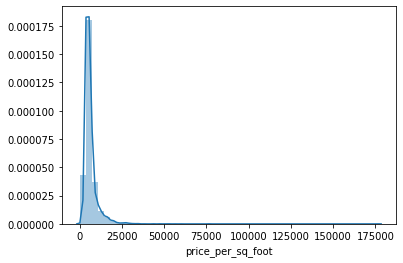

In [131]:
sns.distplot(df7['price_per_sq_foot'])

In [132]:
def remove_pps_outlier(df):
    out_df = pd.DataFrame()
    for key, subdf in df.groupby('location'):
        m = np.mean(subdf.price_per_sq_foot)
        st = np.std(subdf.price_per_sq_foot)
        reduced_df = subdf[(subdf.price_per_sq_foot>(m-st)) & (subdf.price_per_sq_foot<=(m+st))]
        out_df = pd.concat([out_df,reduced_df],ignore_index=True)
    return out_df        

In [133]:
df7.shape

(12485, 6)

In [134]:
df7 = remove_pps_outlier(df7)

In [135]:
df7.shape

(10265, 6)

Visulaize the price comprasion between 2 Bhk and 3 bhk homes

In [136]:
def visualize_bhk(df,location):
    bhk2=df[(df['bhk'] == 2) & (df['location'] == location)]
    bhk3=df[(df['bhk'] == 3 )& (df['location'] == location)]
    plt.figure(figsize=(15,7))
    plt.scatter(x=bhk2.total_sqft,y=bhk2.price,marker="o",label="bhk_2")
    plt.scatter(x=bhk3.total_sqft,y=bhk3.price,marker="+",label="bhk_3")
    plt.xlabel("Total_Sqft")
    plt.ylabel("price")
    plt.legend()

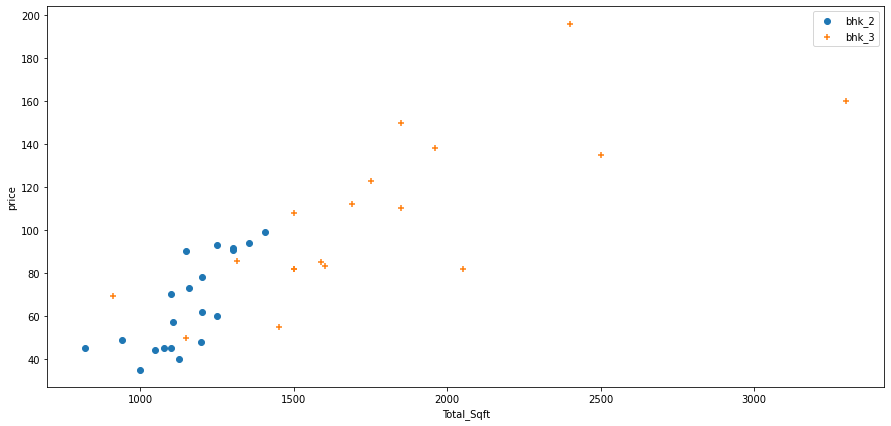

In [137]:
visualize_bhk(df7,'JP Nagar')

We will remove bhk outlier  in differrent locations

In [138]:
def remove_bhk_outlier(df):
    remove_indices = np.array([])
    for locatiion, location_df in df.groupby('location'):
        bhk_stats = {}
        for bhk, bhk_df in location_df.groupby('bhk'):
            bhk_stats[bhk] = {
                'mean':np.mean(bhk_df.price_per_sq_foot),
                'counts':bhk_df.shape[0],
                'std':np.std(bhk_df.price_per_sq_foot)
            }
            
        for bhk, bhk_df in location_df.groupby('bhk'):
            stats = bhk_stats.get(bhk-1)
            if stats and stats['counts']>5:
                remove_indices=np.append(remove_indices, bhk_df[bhk_df.price_per_sq_foot<stats['mean']].index.values)
    return df.drop(remove_indices, axis='index')
df8 = remove_bhk_outlier(df7)

In [139]:
df8.shape #Number of rows reduced to 7353 

(7328, 6)


### Visulaize after removing the outliers
* One can observe that some of ouliters are removed and the data is now more well fitting to a line

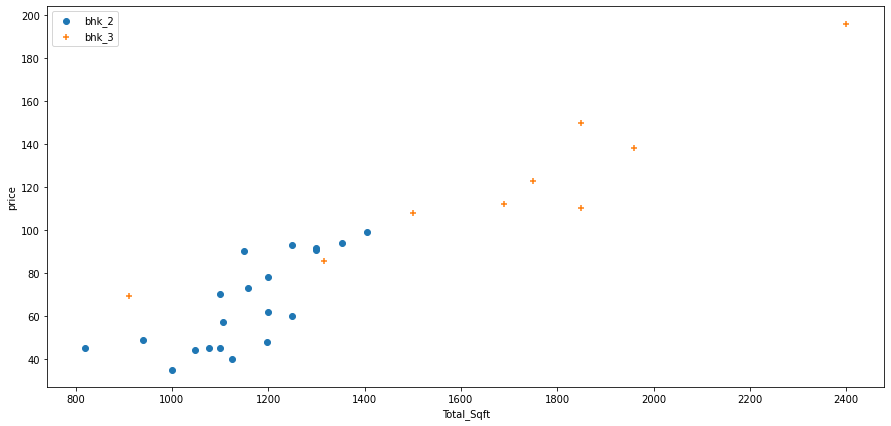

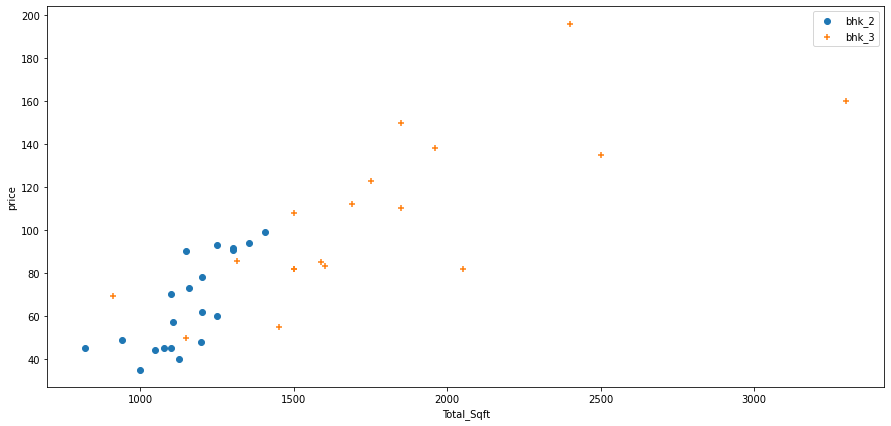

In [140]:
visualize_bhk(df8, 'JP Nagar')
visualize_bhk(df7, 'JP Nagar')

**We can see that the data is more noralized after removing bhk outliers**

Text(0, 0.5, 'Count')

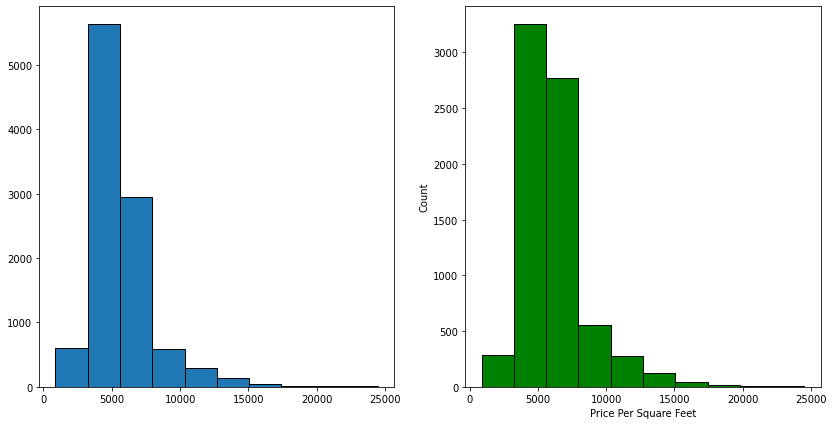

In [141]:
fig,(ax1,ax2) = plt.subplots(1,2,figsize=(14,7))
ax1.hist(df7['price_per_sq_foot'],edgecolor = 'black')
ax2.hist(df8['price_per_sq_foot'],color = 'green',edgecolor='black')
plt.xlabel("Price Per Square Feet")
plt.ylabel("Count")

# Bathroom outliers

In [142]:
df8.bath.unique()

array([  4.,   3.,   2.,   5.,   1.,   8.,   6.,   7.,   9.,  12.,  16.,
        13.])

In [143]:
df8.isnull().sum() # bath have some null values we will drop them

location             0
total_sqft           0
bath                 0
price                0
bhk                  0
price_per_sq_foot    0
dtype: int64

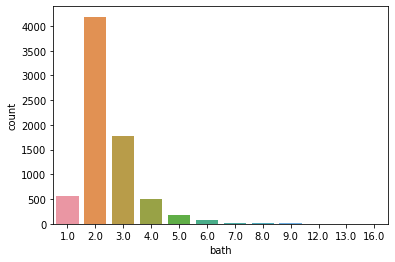

In [144]:
sns.countplot(x='bath',data=df8)

In [145]:
df8[df8.bath >10]

,location,total_sqft,bath,price,bhk,price_per_sq_foot
5289,Neeladri Nagar,4000.0,12.0,160.0,10,4000.000000
8501,other,12000.0,12.0,525.0,10,4375.000000
8590,other,10000.0,16.0,550.0,16,5500.000000
9326,other,6000.0,12.0,150.0,11,2500.000000
9658,other,5425.0,13.0,275.0,13,5069.124424


Remove all house with no. of bathrooms greater than bhk+2

In [146]:
df9 = df8[~(df8.bath>df8.bhk+2)]

In [147]:
df9.shape

(7324, 6)

# One-hot encoding for location

In [148]:
dummies = pd.get_dummies(df9.location)

In [149]:
df10=pd.concat([df9,dummies.drop('other',axis='columns')],axis='columns')

### Dropping columns location, price_per_sqft 

In [150]:
df11 = df10.drop(['location', 'price_per_sq_foot'],axis='columns')

In [151]:
df11.shape

(7324, 244)

# Building Model 

In [193]:
X = df11.drop('price',axis='columns')
y = df11.price

## Spliting data into test and train datasets using test_train_split and  let's try liner regressor to train model

In [153]:
from sklearn.model_selection import train_test_split
train_x, val_x, train_y, val_y = train_test_split(X, y, test_size=.20, random_state=1)

In [154]:
from sklearn.linear_model import LinearRegression

lg_model = LinearRegression()
lg_model.fit(train_x, train_y)
lg_model.score(val_x, val_y)

0.85391610529020223

# Using k-fold cross validation to measure accuracy of algortihm 

In [155]:
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import cross_val_score

cv=ShuffleSplit(n_splits=5, test_size=.2, random_state=2)
scores=cross_val_score(LinearRegression(), X, y, cv=cv)
scores

array([ 0.75267018,  0.78402828,  0.78810513,  0.509096  ,  0.85982201])

# Using Grid search CV

In [156]:
from sklearn.model_selection import GridSearchCV

from sklearn.linear_model import Lasso
from sklearn.tree import DecisionTreeRegressor

def find_best_model_using_gridsearchcv(X, y):
    algos = {
        'linear_regression':{
            'model': LinearRegression(),
            'params': {
                'normalize': [True, False]
            }
        },
        
        'lasso':{
            'model': Lasso(),
            'params': {
                'alpha': [1,2],
                'selection':['random', 'cyclic']
            }
        },
        'decision_tree': {
            'model': DecisionTreeRegressor(),
            'params': {
                'criterion':['mse', 'friedman_mse' ],
                'splitter': ['best','random']
            }
        }
    }
    scores = []
    cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=1)
    for algo_name, settings in algos.items():
        gc = GridSearchCV(settings['model'], settings['params'], cv=cv, return_train_score=False)
        gc.fit(X,y)
        scores.append({
            "algo": algo_name,
            "best_score": gc.best_score_,
            "best_param": gc.best_params_,
            
        })
    return pd.DataFrame(scores, columns=["algo", "best_score", "best_param"])
        

In [157]:
find_best_model_using_gridsearchcv(X, y)
X.col

,algo,best_score,best_param
0,linear_regression,0.751981,{'normalize': False}
1,lasso,0.598297,"{'alpha': 1, 'selection': 'random'}"
2,decision_tree,0.697865,"{'criterion': 'mse', 'splitter': 'random'}"


## We observe that linear_regression performs best
Writing a function to predict price of house given the details


In [84]:
def predict_price(location, total_sqft, bath, bhk ):
    loc_index = np.where(X.columns == location)[0][0]
    x = np.zeros(len(X.columns))
    x[0] = total_sqft
    x[1] = bath
    x[2] = bhk
    x[loc_index] = 1

    return lg_model.predict([x])[0]
    

In [83]:
np.where(X.columns == "Vijayanagar")

(array([], dtype=int64),)

In [166]:
predict_price("Electronic City Phase II",1056, 2 , 2)

35.418165035354761

In [168]:
predict_price("Whitefield", 1170, 2, 4 )

73.819302465598994